In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

1080000


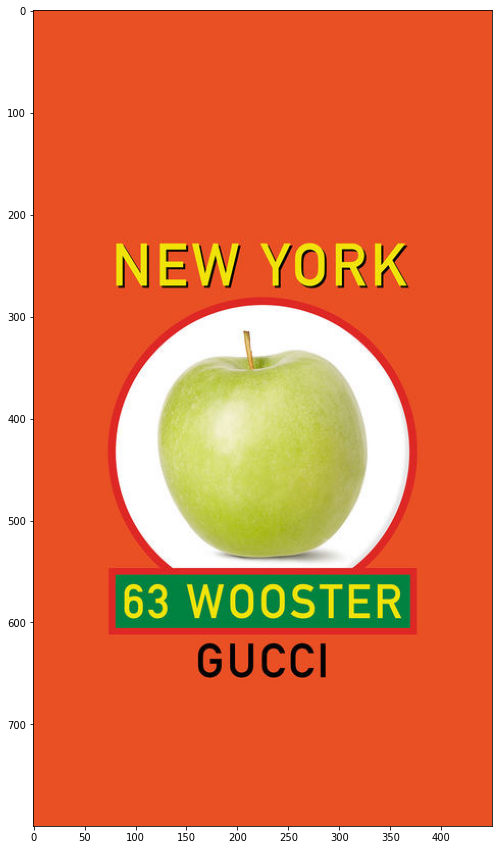

In [5]:
image_path = os.getenv('HOME') +'/aiffel/super_resolution/IMG_0278.JPG'
image = cv2.imread(image_path)
hr_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(hr_image.size)
plt.figure(figsize=(15,15))
plt.imshow(hr_image)

(200, 112, 3)


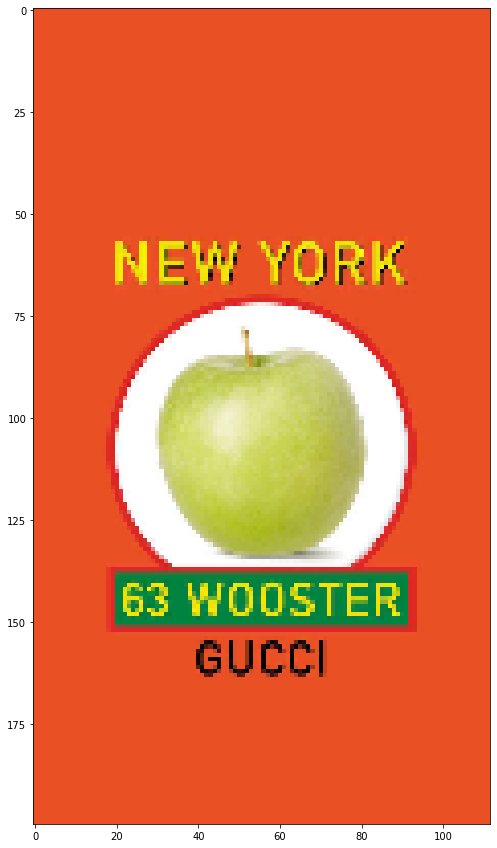

In [6]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(hr_image.shape[1]//4,
                                       hr_image.shape[0]//4)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(15,15))
plt.imshow(lr_image)

In [7]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [8]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /aiffel/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


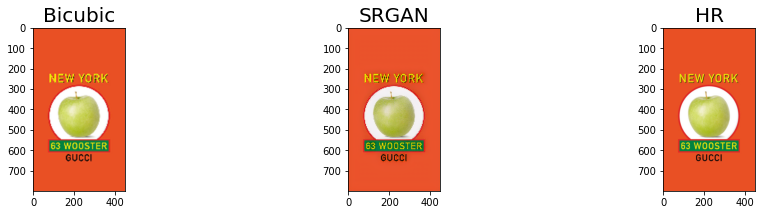

In [9]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

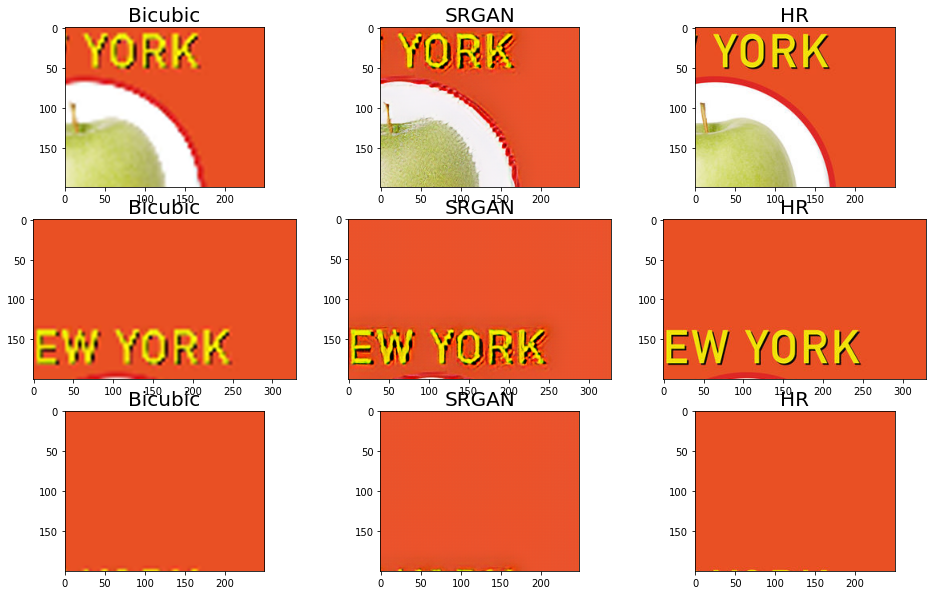

In [10]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=200, y=350):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

 ##     글자부분은 더 선명하게 보이지만 사과의 무늬같은 텍스쳐는 더 일그러져 보인다 작은 이미지로 봤을때는 SRGAN이 나아보인다

In [11]:
import os
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture(os.getenv('HOME') +'/aiffel/super_resolution/city_night_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


In [15]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*2, frame.shape[0]*2), 
        interpolation=cv2.INTER_CUBIC
    ))

    frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

In [16]:
import imageio

imageio.mimsave((os.getenv('HOME') +'/aiffel/super_resolution/city_night_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave((os.getenv('HOME') +'/aiffel/super_resolution/city_night_hr_srgan.gif'), frames_sr_srgan)


![city_night_lr](https://user-images.githubusercontent.com/91672146/146421082-86cb3b45-5444-4325-bfe6-5a04cde0208e.gif)
![city_night_hr_bicubic](https://user-images.githubusercontent.com/91672146/146421995-ff1653ef-d130-412d-bb4e-2b3cd90f3884.jpg)
![city_night_hr_srgan](https://user-images.githubusercontent.com/91672146/146422017-a91b1442-1393-43b5-83db-3fcd796ca69d.jpg)


용량상 확장된것은 이미지로 첨부하였습니다. 사과 텍스쳐와는 다르게 확실히이 풍경에서는 SRGAN이 화질이 훨신 좋다.